## VODAFONE CUSTOMER CHURN ANALYSIS - TEAM PRETORIA - LP2

#### SETUP

##### INSTALLING RELEVAT LIBRARIES


%pip install database interaction library
%pip install pyodbc
%pip install plotly
%pip install statsmodels
%pip install imblearn 
%pip install openpyxl
%pip install phik
%pip install xgboost

#### IMPORTATION OF LIBRARIES 

In [107]:
##Data Handling
import pandas as pd
import numpy as np
import pyodbc
import statsmodels.api as sm

##Visualization Libraries 
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns 
import random
import plotly.offline as offline
offline.init_notebook_mode(connected=True) # Configure Plotly to run offline


# Feature Processing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import phik
from phik.report import plot_correlation_matrix
from phik import report

#Algorithms libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split
import xgboost

##pipelines and transformers 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from sklearn.pipeline import make_pipeline

##handling imbalance datasets
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

##hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

##for hypothesis testing 
from scipy.stats import chi2_contingency

##model evaluation:
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

# Other packages
import os
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

#### DATA LOADING

In [108]:
# create server instance variables
server = 'dap-projects-database.database.windows.net'
database = 'dapDB'
username = 'dataAnalyst_LP2'
password = 'A3g@3kR$2y'


#Establish connection with server 
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [109]:
#Connecting to the Server
connection = pyodbc.connect(connection_string)

In [110]:
#Get data from server with query 'Select *'
query = "Select * from dbo.LP2_Telco_churn_first_3000"
sql_data = pd.read_sql(query, connection)

In [111]:
sql_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [112]:
sql_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [113]:
#read csv for remaining data from GitHub repository
data = pd.read_csv('LP2_Telco-churn-last-2000.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [114]:
onedrive_data = pd.read_excel('Telco-churn-second-2000.xlsx')


In [115]:
#Merge dataset
voda_churn_train = pd.concat([sql_data, data])
voda_churn_train.to_csv('voda_customer_churn.csv')

#### EXPLORATORY DATA ANALYSIS 

Null Hypothesis: Customers with high monthly charges do not have the tendency to churn 

Alt Hypothesis: Customers with high monthly Charges have the tendency to churn 


Questions 
- How much total charges and Monthly charges did churners generate? 
- Are customers with dependents likely to have higher charges than those without dependents?
- How many Senior Citizens with dependents churn?
- Which internet service is most preferred?
- What is the most common payment method?

In [116]:
voda_df = pd.read_csv('voda_customer_churn.csv')

In [117]:
voda_df.head()

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,7590-VHVEG,Female,False,True,False,1,False,NaN,DSL,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000381469727,False
1,1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.1500015258789,True
3,3,7795-CFOCW,Male,False,False,False,45,False,NaN,DSL,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.64999389648438,True


In [118]:
voda_df.shape

(5043, 22)

In [119]:
voda_df = voda_df.drop('Unnamed: 0', axis = 'columns')

In [120]:
voda_df.shape

(5043, 21)

In [121]:
voda_df.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

In [122]:
#Checking the data types of the columns
voda_df.dtypes

customerID           object
gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [123]:
voda_df.describe()

,tenure,MonthlyCharges
count,5043.000000,5043.000000
mean,32.576641,65.090214
std,24.529807,30.068133
min,0.000000,18.400000
25%,9.000000,35.775000
50%,29.000000,70.550003
75%,56.000000,90.050003
max,72.000000,118.650002


75% customers have tenure less than 55 months

Average Monthly charges are USD 64.76 whereas 25% customers pay more than USD 89.85 per month

Text(0.5, 1.0, 'Count of Target Variable per Category')

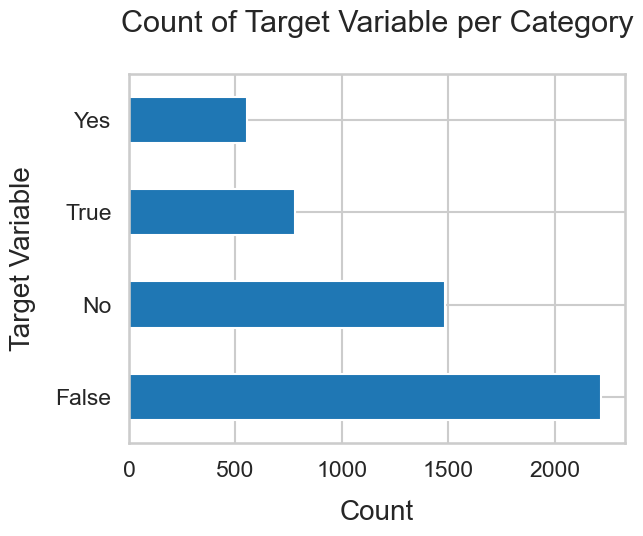

In [124]:
voda_df['Churn'].value_counts().plot(kind='barh')
plt.xlabel("Count", labelpad=14)
plt.ylabel("Target Variable", labelpad=14)
plt.title("Count of Target Variable per Category")

In [125]:
voda_df['Churn'].value_counts()

False    2219
No       1487
True      780
Yes       556
Name: Churn, dtype: int64

* The total value count is less than expected. Possibly missing values. Will be looked at during cleaning.
* Nonetheless, data looks highly imbalanced
* So we analyse the data with other features while taking the target values separately to get some insights.

In [126]:
# To have a concise look at the dataframe we will use verbose = True mode
voda_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   object 
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 


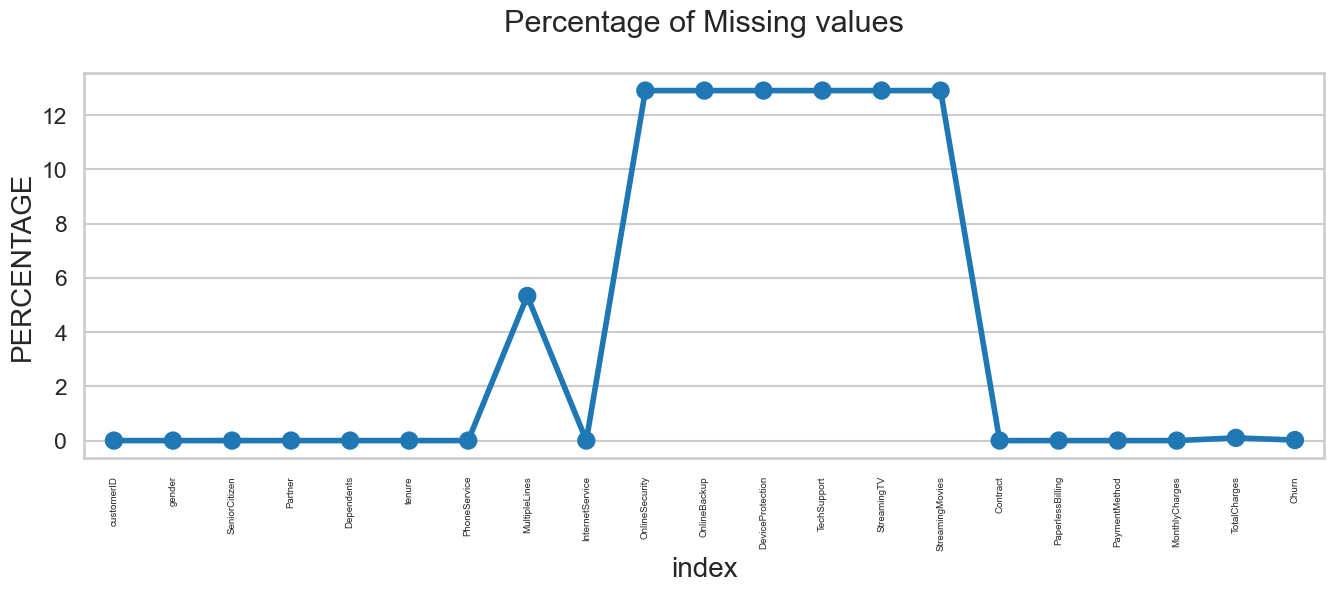

In [127]:
missing = pd.DataFrame((voda_df.isnull().sum())*100/voda_df.shape[0]).reset_index()
plt.figure(figsize=(16,5))
ax = sns.pointplot('index',0,data=missing)
plt.xticks(rotation =90,fontsize =7)
plt.title("Percentage of Missing values")
plt.ylabel("PERCENTAGE")
plt.show()

A point plot presentation of missing values in percentage shows our target variable has about 25% values missing. We would have to look at that in data cleaning

### Missing Data - Initial Intuition

General Thumb Rules:

* For features with less missing values- can use regression to predict the missing values or fill with the mean of the values present, depending on the feature.
* For features with very high number of missing values- it is better to drop those columns as they give very less insight on analysis.
* As there's no thumb rule on what criteria do we delete the columns with high number of missing values, but generally you can delete the columns, if you have more than 30-40% of missing values. But again there's a catch here, for example, Is_Car & Car_Type, People having no cars, will obviously have Car_Type as NaN (null), but that doesn't make this column useless, so decisions has to be taken wisely.

## Data Cleaning

**1.** Create a copy of base data for manupulation & processing

In [128]:
voda_data = voda_df.copy()

**2** From Data understanding above we realized that Total Charges is object and needs to be changed to numeric

In [129]:
voda_data.TotalCharges = pd.to_numeric(voda_data.TotalCharges, errors='coerce')
voda_data.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          8
Churn                 1
dtype: int64

**3** As we can see, there are 8 missing values in TotalCharges Column. Let us have a look at these records

In [130]:
voda_data.loc[voda_data['TotalCharges'].isnull() == True]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,False,True,True,0,False,NaN,DSL,True,...,True,True,True,False,Two year,True,Bank transfer (automatic),52.549999,NaN,False
753,3115-CZMZD,Male,False,False,True,0,True,False,No,NaN,...,NaN,NaN,NaN,NaN,Two year,False,Mailed check,20.250000,NaN,False
936,5709-LVOEQ,Female,False,True,True,0,True,False,DSL,True,...,True,False,True,True,Two year,False,Mailed check,80.849998,NaN,False
1082,4367-NUYAO,Male,False,True,True,0,True,True,No,NaN,...,NaN,NaN,NaN,NaN,Two year,False,Mailed check,25.750000,NaN,False
1340,1371-DWPAZ,Female,False,True,True,0,False,NaN,DSL,True,...,True,True,True,False,Two year,False,Credit card (automatic),56.049999,NaN,False
3218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.700000,NaN,No
4670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.350000,NaN,No
4754,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,...,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.900000,NaN,No


**4** We would fill the missing values in the TotalCharges Column with the mean

In [131]:
voda_data['TotalCharges'].fillna(value= voda_data["TotalCharges"].mean(), inplace= True)

**5** We are going to categorized the customers base on tenure e.g. for tenure < 12 months: assign a tenure group if 1-12, for tenure between 1 to 2 Yrs, tenure group of 13-24; so on...

In [132]:
#Get the max tenure
print(voda_data['tenure'].max())

72


In [133]:
#Group tenure in basket of 12 months
labels = ["{0} - {1}".format(i, i + 11) for i in range(1, 72, 12)]

voda_data['tenure_group'] = pd.cut(voda_data.tenure, range(1,84,12), right=False, labels=labels)

In [134]:
#View basket
voda_data['tenure_group'].value_counts()

1 - 12     1534
61 - 72    1017
13 - 24     732
25 - 36     603
49 - 60     590
37 - 48     559
Name: tenure_group, dtype: int64

**6** Drop columns not required for processing

In [135]:
#Drop the column CustomerID and tenure
voda_data.drop(columns=['customerID','tenure'],axis=1,inplace=True)
voda_data.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,Female,False,True,False,False,NaN,DSL,False,True,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False,1 - 12
1,Male,False,False,False,True,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False,25 - 36
2,Male,False,False,False,True,False,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True,1 - 12
3,Male,False,False,False,False,NaN,DSL,True,False,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False,37 - 48
4,Female,False,False,False,True,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True,1 - 12


**7** Unifying the Churn Column Values

In [136]:
#Churn Column
voda_data['Churn'] = voda_data['Churn'].str.replace('False', 'No')
voda_data['Churn'] = voda_data['Churn'].str.replace('True', 'Yes')

#Senior Citizen Column 
voda_data['SeniorCitizen'] = voda_data['SeniorCitizen'].str.replace( '0','False')
voda_data['SeniorCitizen'] = voda_data['SeniorCitizen'].str.replace('1','True')

#Partner Column 
voda_data['Partner'] = voda_data['Partner'].str.replace('False', 'No')
voda_data['Partner'] = voda_data['Partner'].str.replace('True', 'Yes')

#Online Security 
voda_data['OnlineSecurity'] = voda_data['OnlineSecurity'].str.replace('False', 'No')
voda_data['OnlineSecurity'] = voda_data['OnlineSecurity'].str.replace('True', 'Yes')

#Dependents Column
voda_data['Dependents'] = voda_data['Dependents'].str.replace('False', 'No')
voda_data['Dependents'] = voda_data['Dependents'].str.replace('True', 'Yes')

#PhoneService Column
voda_data['PhoneService'] = voda_data['PhoneService'].str.replace('False', 'No')
voda_data['PhoneService'] = voda_data['PhoneService'].str.replace('True', 'Yes')

#MultipleLines Column
voda_data['MultipleLines'] = voda_data['MultipleLines'].str.replace('False', 'No')
voda_data['MultipleLines'] = voda_data['MultipleLines'].str.replace('True', 'Yes')

#Online Backup 
voda_data['OnlineBackup'] = voda_data['OnlineBackup'].str.replace('False', 'No')
voda_data['OnlineBackup'] = voda_data['OnlineBackup'].str.replace('True', 'Yes')

#DeviceProtection
voda_data['DeviceProtection'] = voda_data['DeviceProtection'].str.replace('False', 'No')
voda_data['DeviceProtection'] = voda_data['DeviceProtection'].str.replace('True', 'Yes')

#TechSupport
voda_data['TechSupport'] = voda_data['TechSupport'].str.replace('False', 'No')
voda_data['TechSupport'] = voda_data['TechSupport'].str.replace('True', 'Yes')

#TechSupport
voda_data['TechSupport'] = voda_data['TechSupport'].str.replace('False', 'No')
voda_data['TechSupport'] = voda_data['TechSupport'].str.replace('True', 'Yes')

#StreamingTV
voda_data['StreamingTV'] = voda_data['StreamingTV'].str.replace('False', 'No')
voda_data['StreamingTV'] = voda_data['StreamingTV'].str.replace('True', 'Yes')

#StreamingMovies
voda_data['StreamingMovies'] = voda_data['StreamingMovies'].str.replace('False', 'No')
voda_data['StreamingMovies'] = voda_data['StreamingMovies'].str.replace('True', 'Yes')

#PaperlessBilling
voda_data['PaperlessBilling'] = voda_data['PaperlessBilling'].str.replace('False', 'No')
voda_data['PaperlessBilling'] = voda_data['PaperlessBilling'].str.replace('True', 'Yes')

## Data Exploration

**1** Plot of individual predictors by churn

### Univariate Analysis

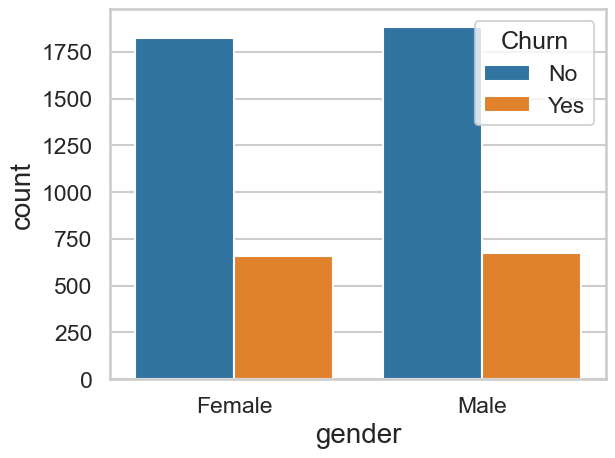

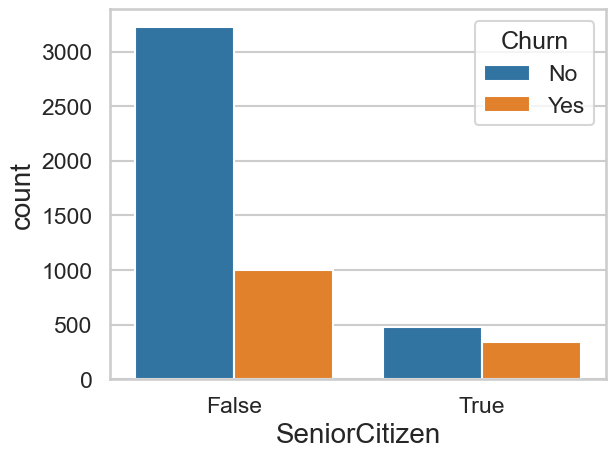

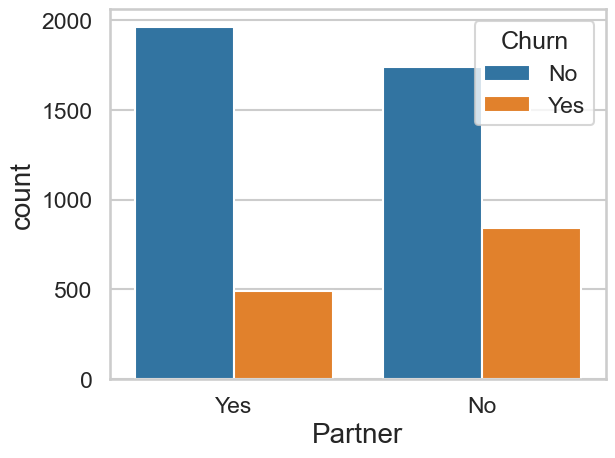

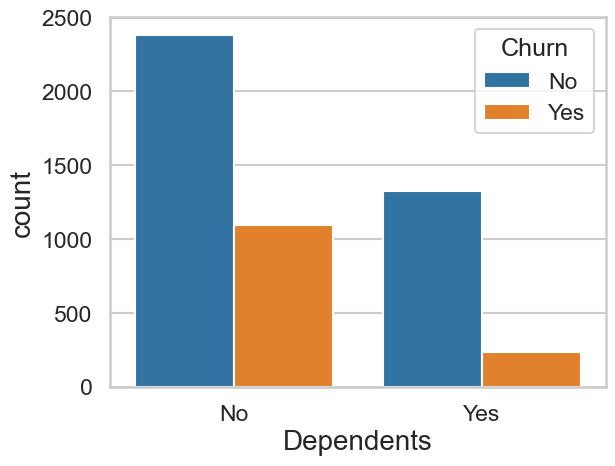

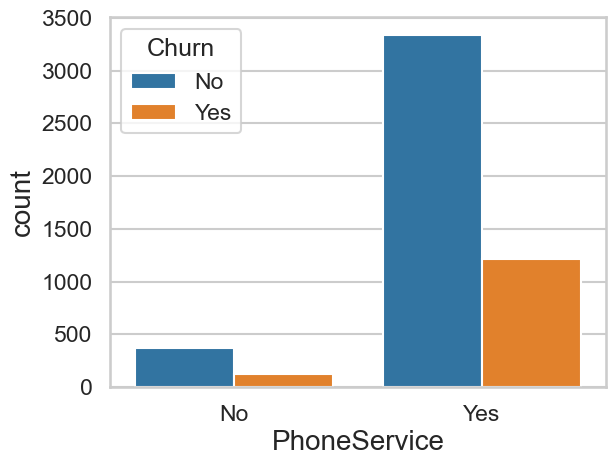

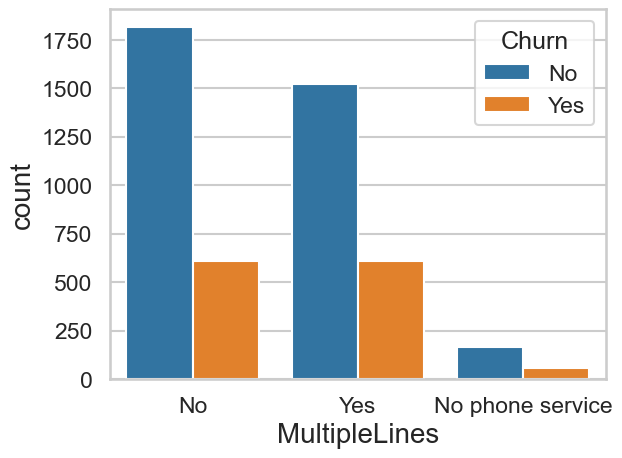

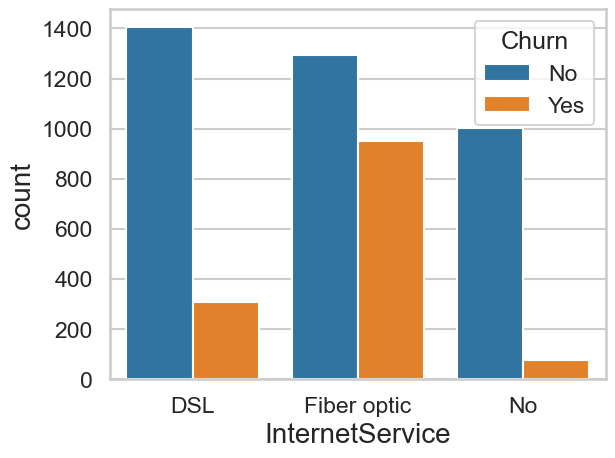

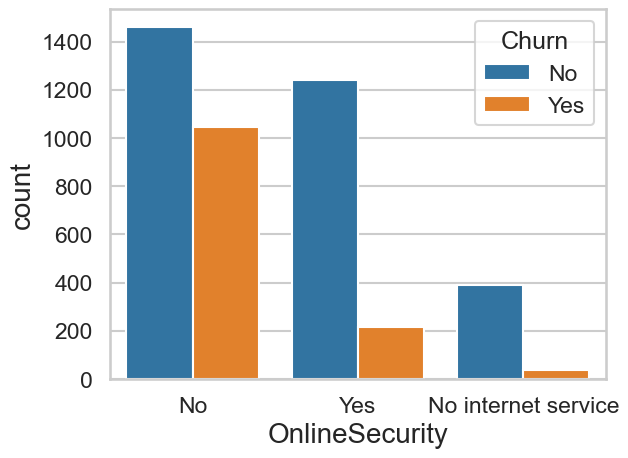

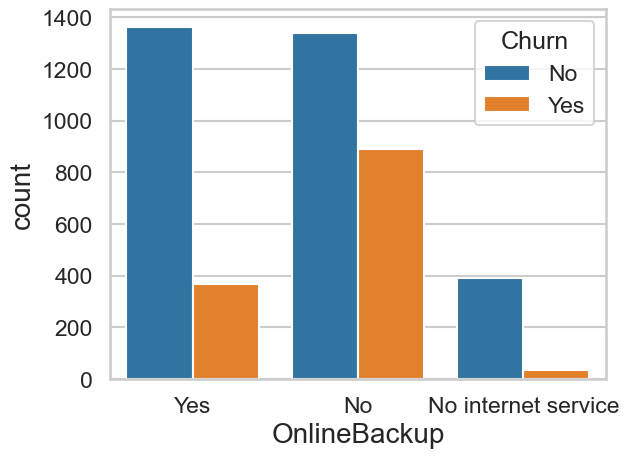

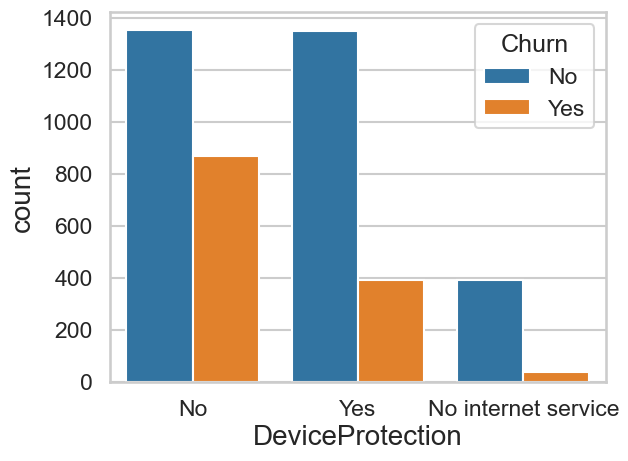

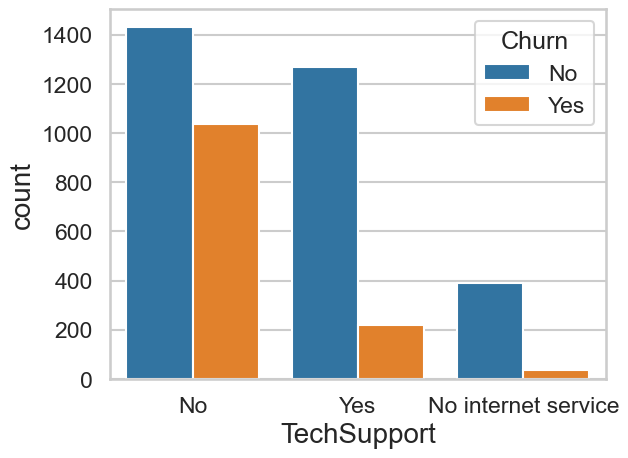

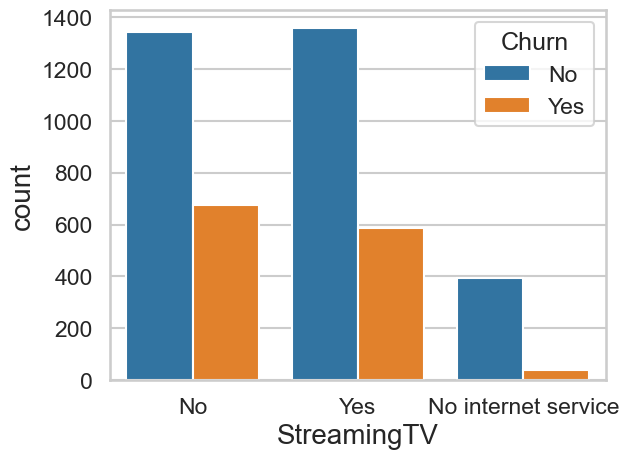

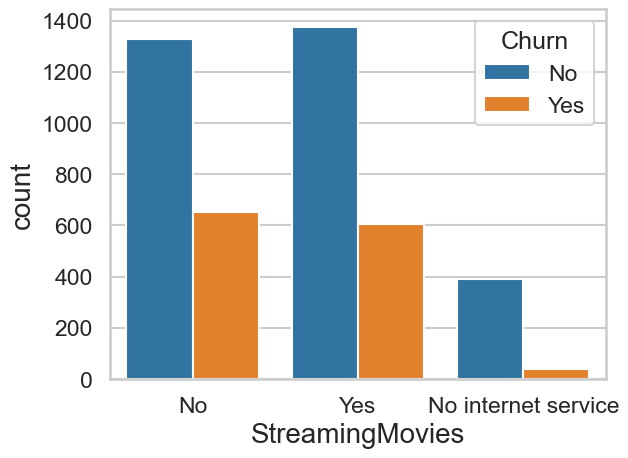

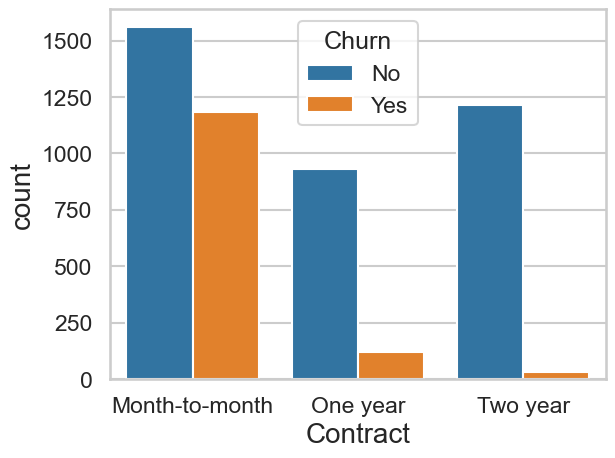

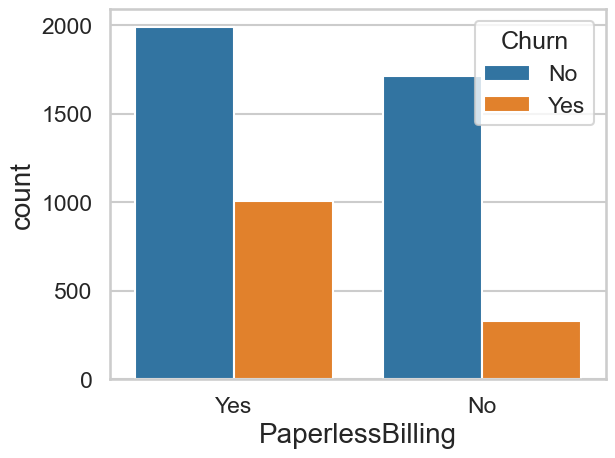

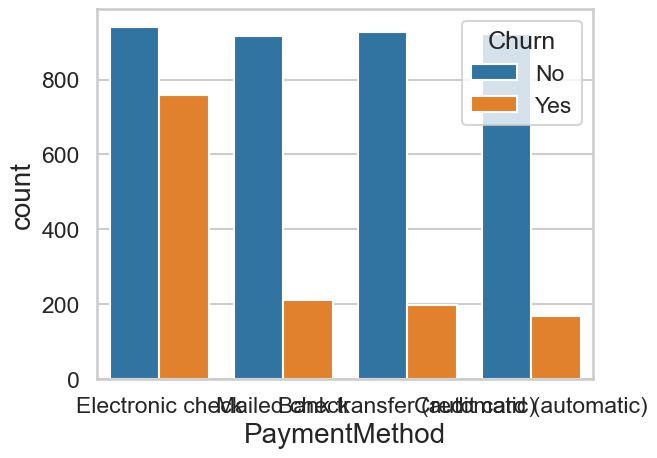

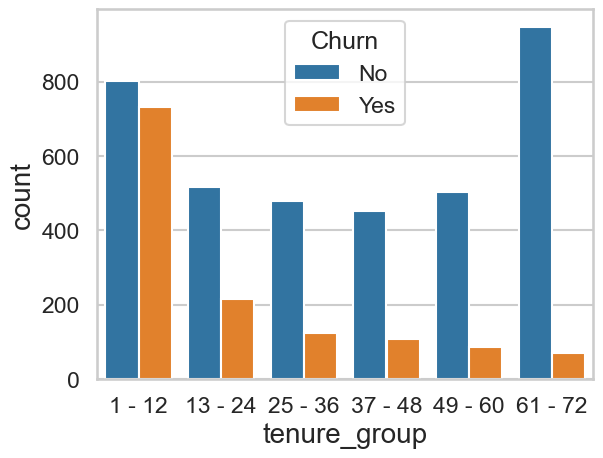

In [137]:
for i, predictor in enumerate(voda_data.drop(columns=['Churn', 'TotalCharges', 'MonthlyCharges'])):
    plt.figure(i)
    sns.countplot(data=voda_data, x=predictor, hue='Churn')

**2.** Convert the target variable 'Churn'  in a binary numeric variable i.e. Yes=1 ; No = 0

In [138]:
voda_data['Churn'] = np.where(voda_data.Churn == 'Yes',1,0)

In [139]:
voda_data.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,Female,False,Yes,No,No,NaN,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000,0,1 - 12
1,Male,False,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.500000,0,25 - 36
2,Male,False,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002,1,1 - 12
3,Male,False,No,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.750000,0,37 - 48
4,Female,False,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.649994,1,1 - 12


**3.** Converting all the categorical variables into dummy variables

In [140]:
voda_data_dummies = pd.get_dummies(voda_data)
voda_data_dummies.head()

,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_False,SeniorCitizen_True,Partner_No,Partner_Yes,Dependents_No,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,29.850000,29.850000,0,1,0,1,0,0,1,1,...,0,0,1,0,1,0,0,0,0,0
1,56.950001,1889.500000,0,0,1,1,0,1,0,1,...,0,0,0,1,0,0,1,0,0,0
2,53.849998,108.150002,1,0,1,1,0,1,0,1,...,0,0,0,1,1,0,0,0,0,0
3,42.299999,1840.750000,0,0,1,1,0,1,0,1,...,1,0,0,0,0,0,0,1,0,0
4,70.699997,151.649994,1,1,0,1,0,1,0,1,...,0,0,1,0,1,0,0,0,0,0


**4** Relationship between Monthly Charges and Total Charges

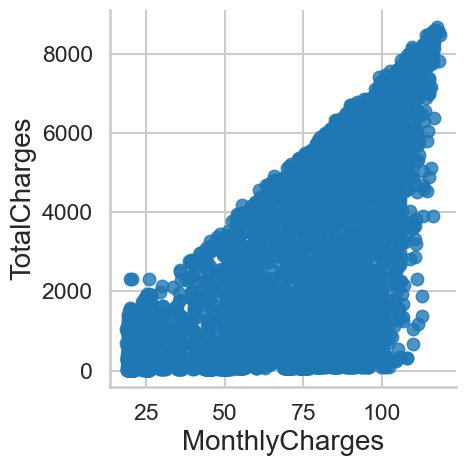

In [141]:
sns.lmplot(data=voda_data_dummies, x='MonthlyCharges', y='TotalCharges', fit_reg=False)

It could be observed that as Total Charges increases, Monthly Charges increases as expected

**5** Churn by Monthly Charges and Total Charges

Text(0.5, 1.0, 'Monthly charges by churn')

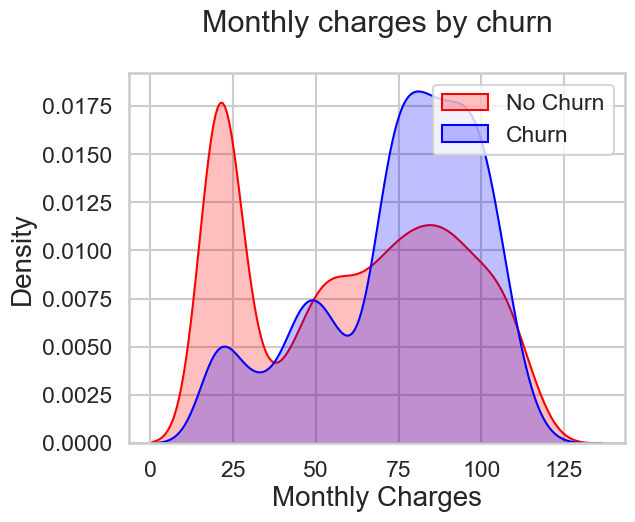

In [142]:
Mth = sns.kdeplot(voda_data_dummies.MonthlyCharges[(voda_data_dummies["Churn"] == 0) ],
                color="Red", shade = True)
Mth = sns.kdeplot(voda_data_dummies.MonthlyCharges[(voda_data_dummies["Churn"] == 1) ],
                ax =Mth, color="Blue", shade= True)
Mth.legend(["No Churn","Churn"],loc='upper right')
Mth.set_ylabel('Density')
Mth.set_xlabel('Monthly Charges')
Mth.set_title('Monthly charges by churn')

**Insight:** Churn is high when Monthly Charges ar high

Text(0.5, 1.0, 'Total charges by churn')

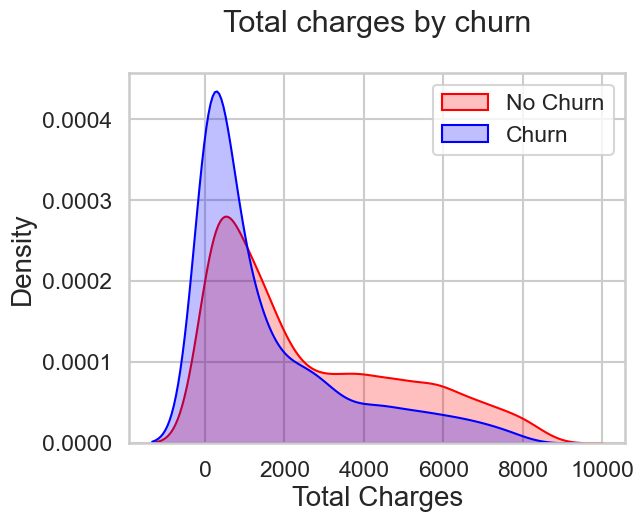

In [143]:
Tot = sns.kdeplot(voda_data_dummies.TotalCharges[(voda_data_dummies["Churn"] == 0) ],
                color="Red", shade = True)
Tot = sns.kdeplot(voda_data_dummies.TotalCharges[(voda_data_dummies["Churn"] == 1) ],
                ax =Tot, color="Blue", shade= True)
Tot.legend(["No Churn","Churn"],loc='upper right')
Tot.set_ylabel('Density')
Tot.set_xlabel('Total Charges')
Tot.set_title('Total charges by churn')

**Surprising insight ** Higher Churn at lower Total Charges

However if we combine the insights of 3 parameters i.e. Tenure, Monthly Charges & Total Charges then the picture is bit clear :- Higher Monthly Charge at lower tenure results into lower Total Charge. Hence, all these 3 factors viz **Higher Monthly Charge**,  **Lower tenure** and **Lower Total Charge** are linkd to **High Churn**.

**6** Build a corelation of all predictors with 'Churn'

<AxesSubplot:>

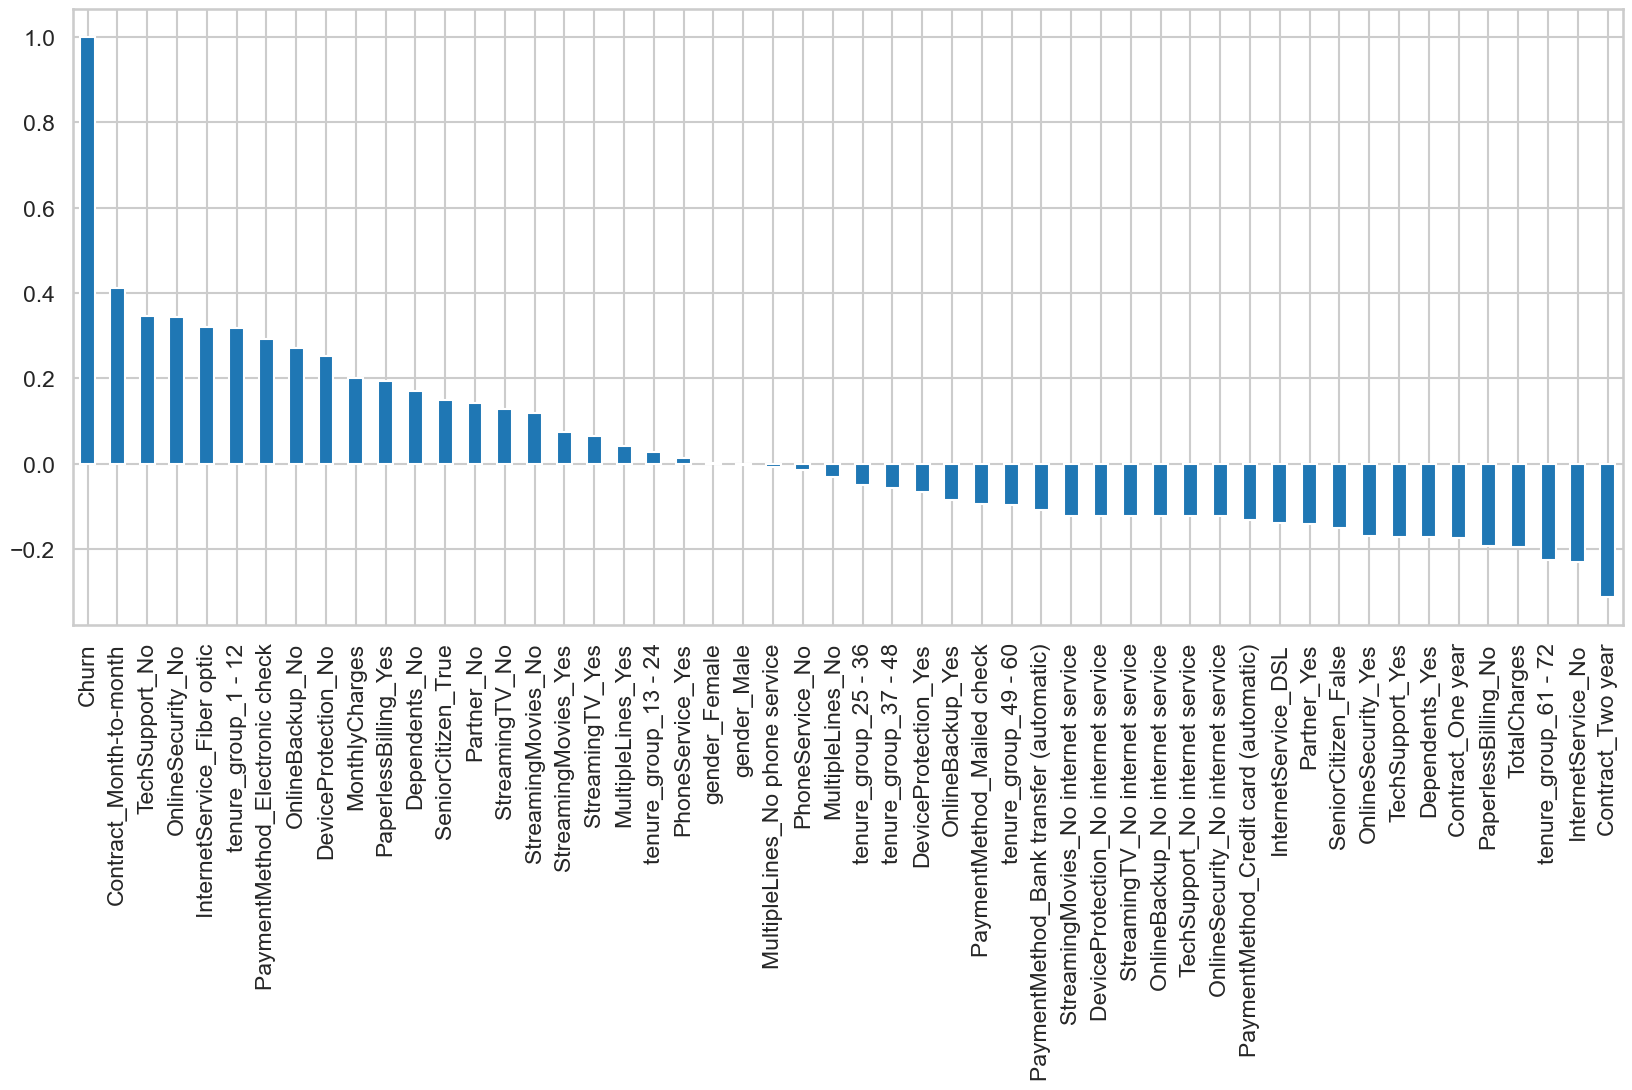

In [144]:
plt.figure(figsize=(20,8))
voda_data_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

**Derived Insight: **

**HIGH** Churn seen in case of  **Month to month contracts**, **No Tech support**, **No online security**, **Fibre Optics Internet** and **First year of subscription**

**LOW** Churn is seens in case of **Long term contracts**, **Subscriptions without internet service** and **The customers engaged for 5+ years**

Factors like **Gender**, **Availability of PhoneService** and **# of multiple lines** have alomost **NO** impact on Churn

This is also evident from the **Heatmap** below

<AxesSubplot:>

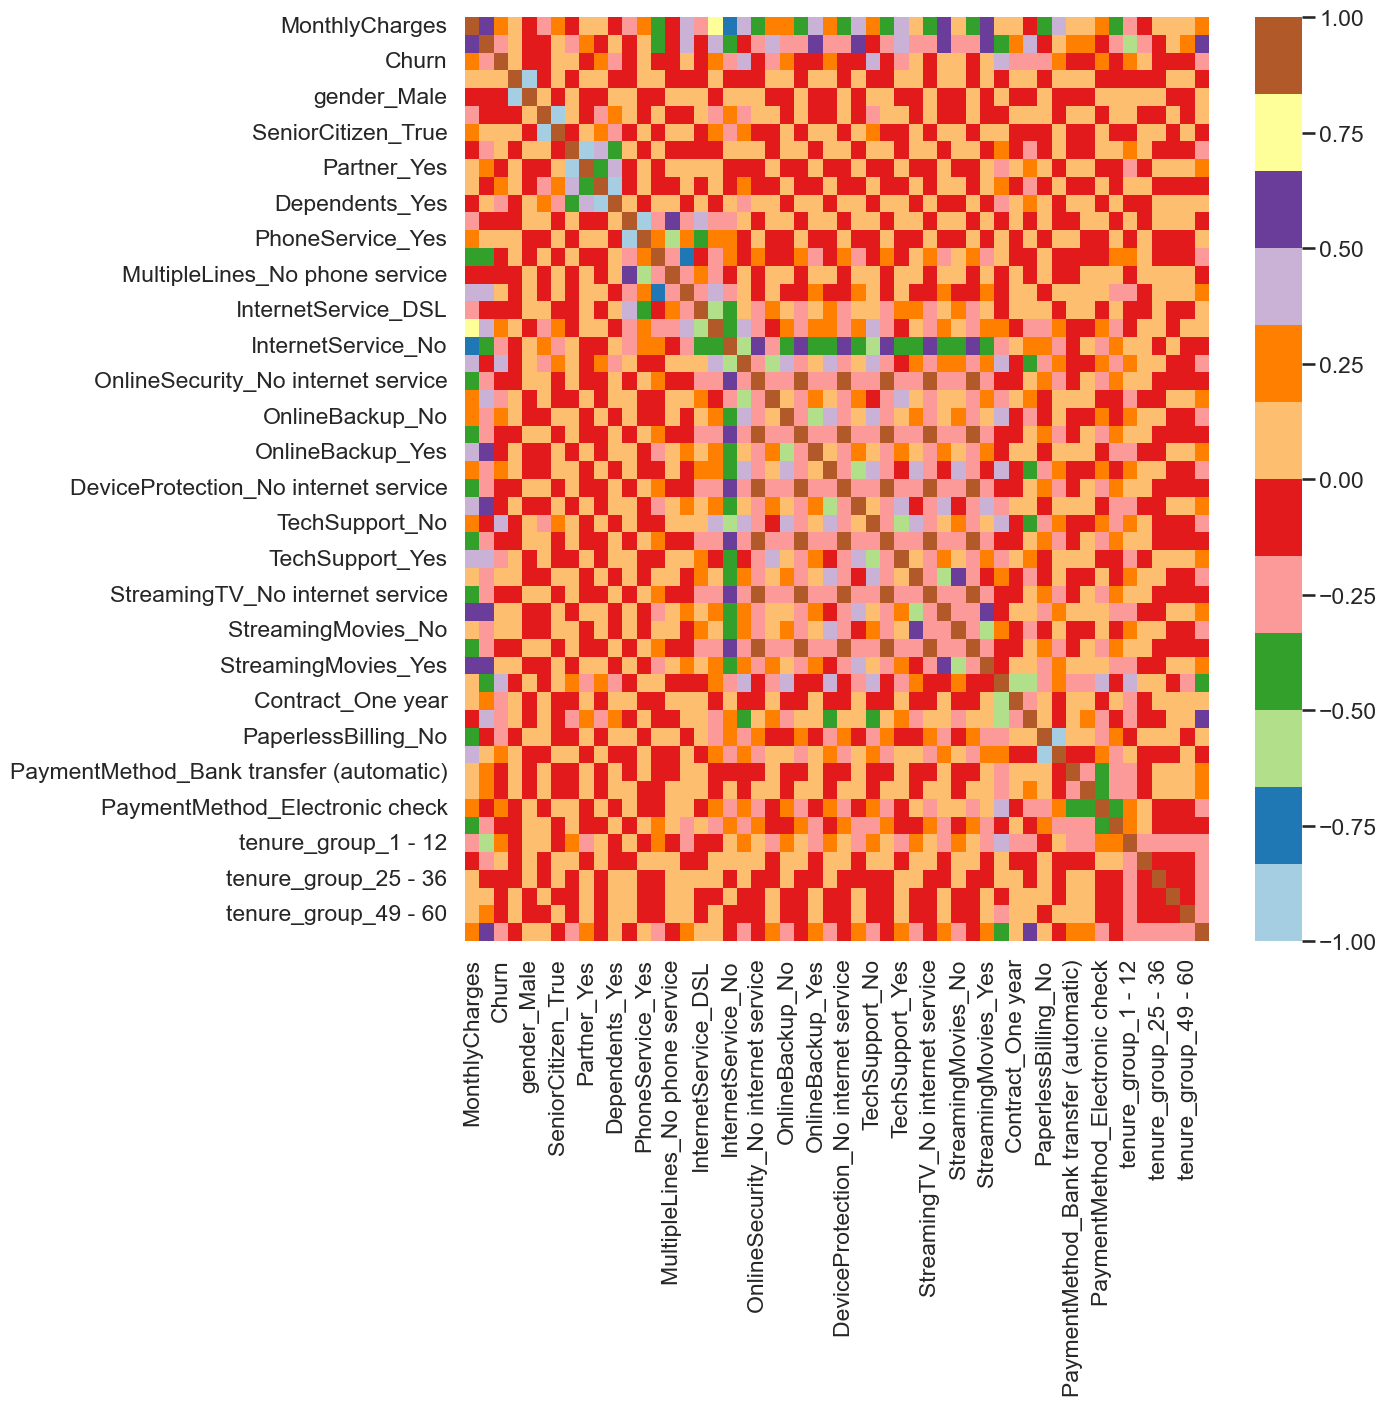

In [145]:
plt.figure(figsize=(12,12))
sns.heatmap(voda_data_dummies.corr(), cmap="Paired")

### Bivariate Analysis

In [146]:
new_df1_target0=voda_data.loc[voda_data["Churn"]==0]
new_df1_target1=voda_data.loc[voda_data["Churn"]==1]

In [147]:
def uniplot(df,col,title,hue =None):
    
    sns.set_style('whitegrid')
    sns.set_context('talk')
    plt.rcParams["axes.labelsize"] = 20
    plt.rcParams['axes.titlesize'] = 22
    plt.rcParams['axes.titlepad'] = 30
    
    
    temp = pd.Series(data = hue)
    fig, ax = plt.subplots()
    width = len(df[col].unique()) + 7 + 4*len(temp.unique())
    fig.set_size_inches(width , 8)
    plt.xticks(rotation=45)
    plt.yscale('log')
    plt.title(title)
    ax = sns.countplot(data = df, x= col, order=df[col].value_counts().index,hue = hue,palette='bright') 
        
    plt.show()

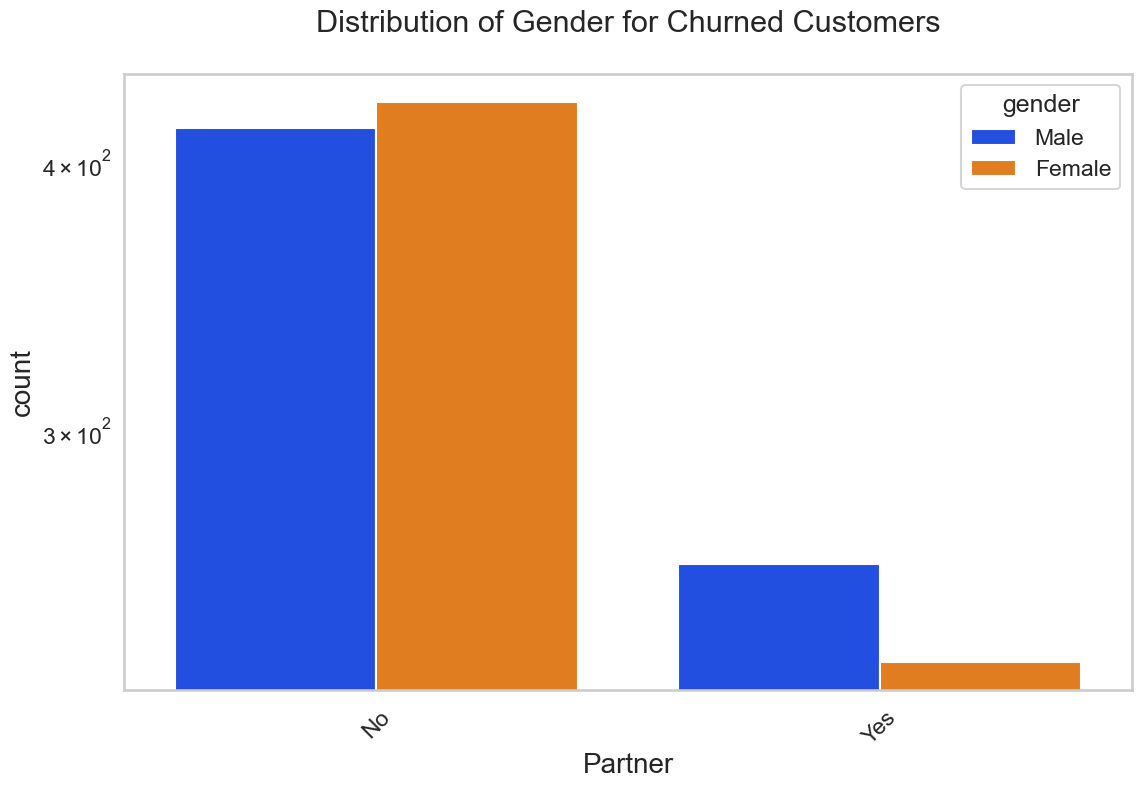

In [148]:
uniplot(new_df1_target1,col='Partner',title='Distribution of Gender for Churned Customers',hue='gender')

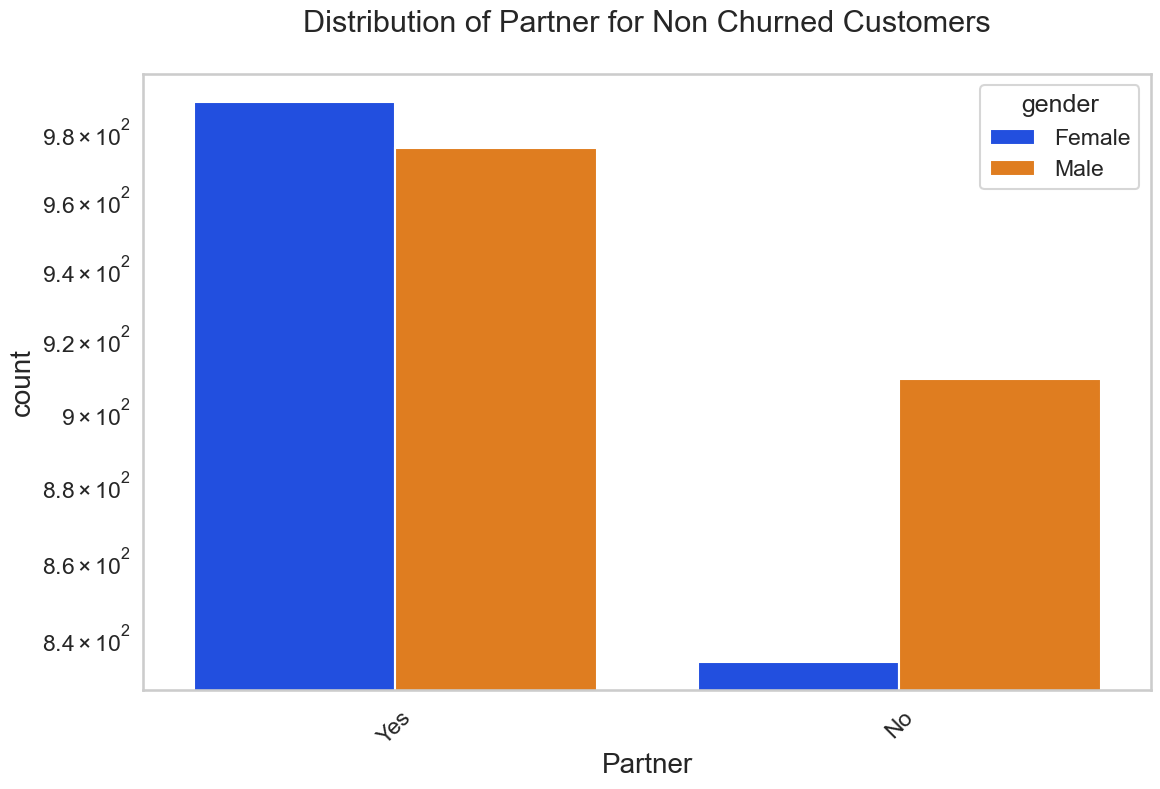

In [149]:
uniplot(new_df1_target0,col='Partner',title='Distribution of Partner for Non Churned Customers',hue='gender')

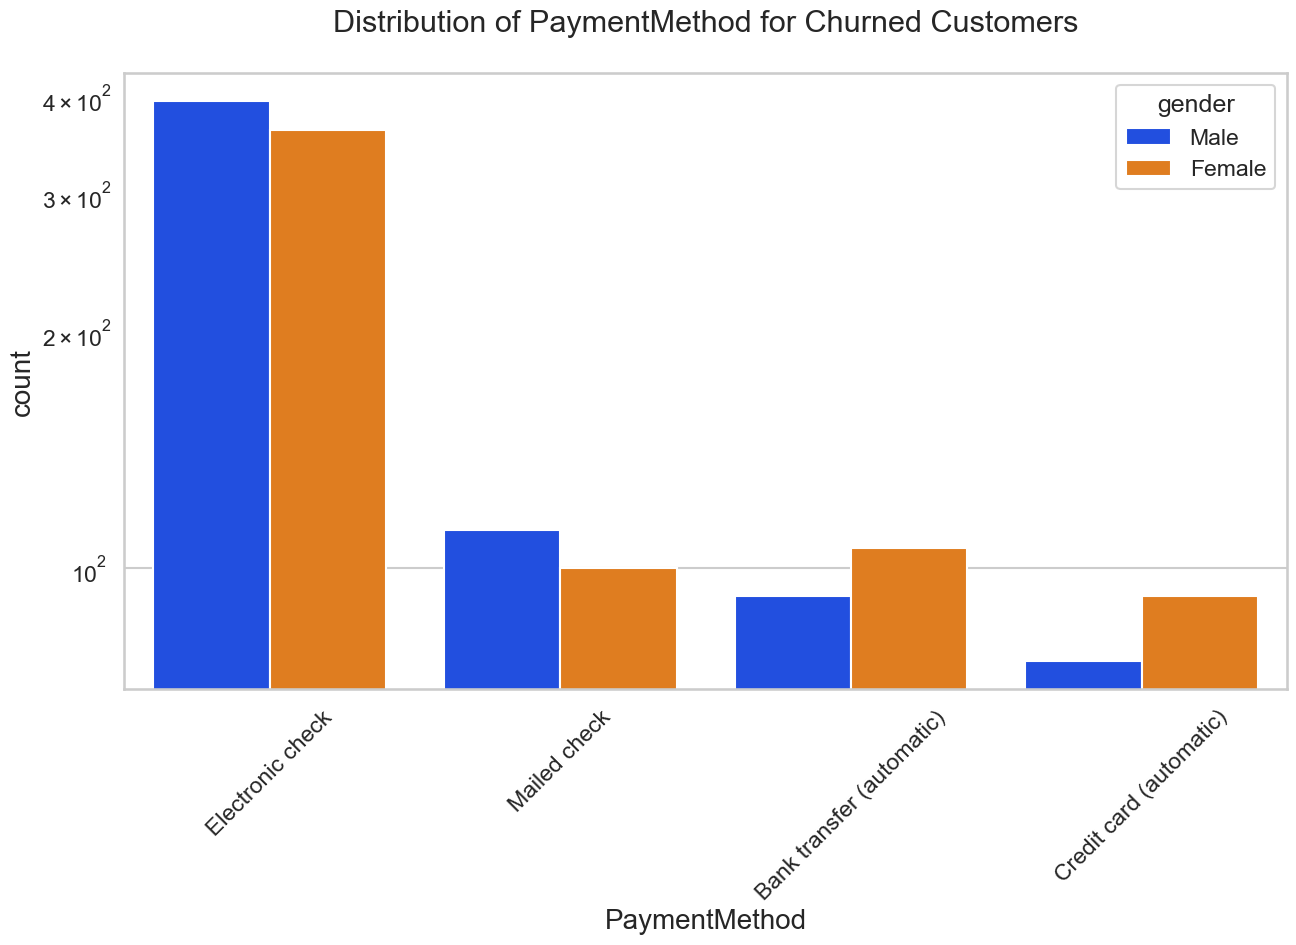

In [150]:
uniplot(new_df1_target1,col='PaymentMethod',title='Distribution of PaymentMethod for Churned Customers',hue='gender')

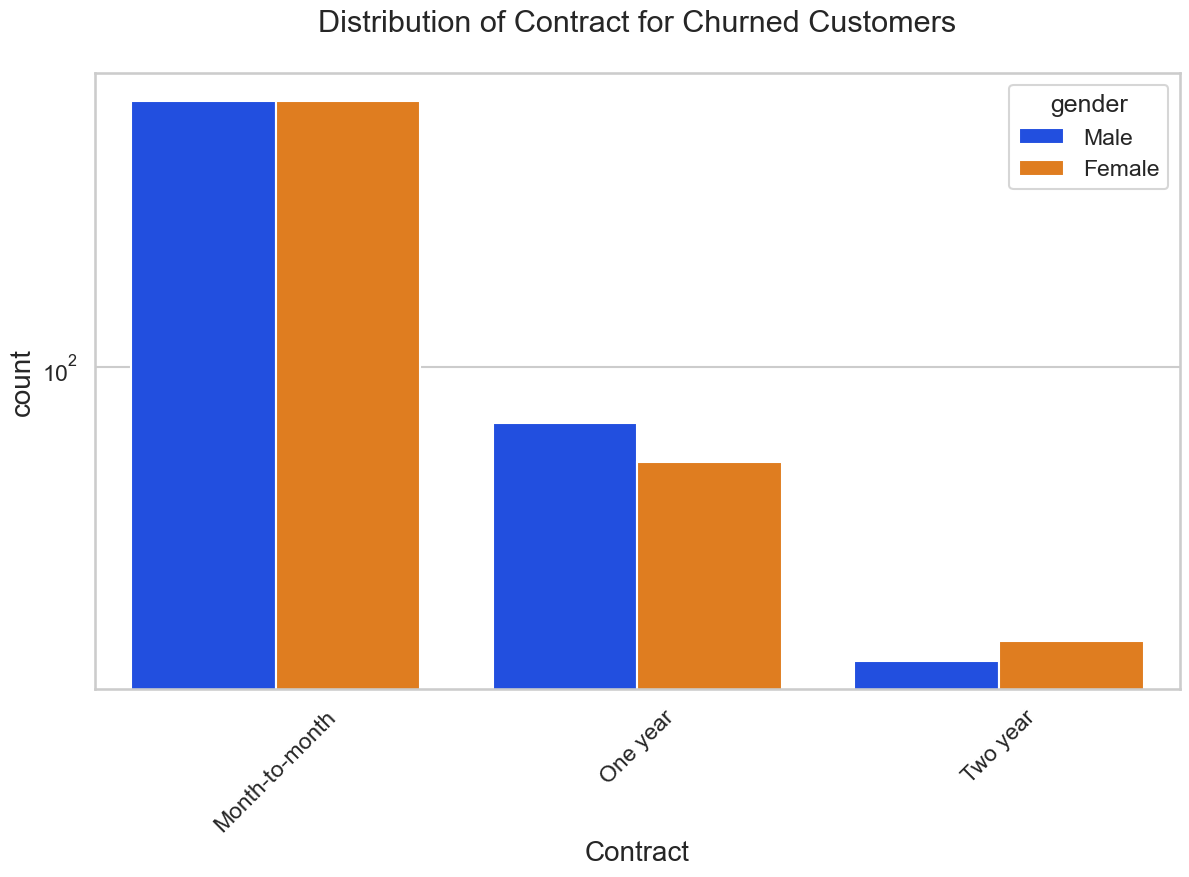

In [151]:
uniplot(new_df1_target1,col='Contract',title='Distribution of Contract for Churned Customers',hue='gender')

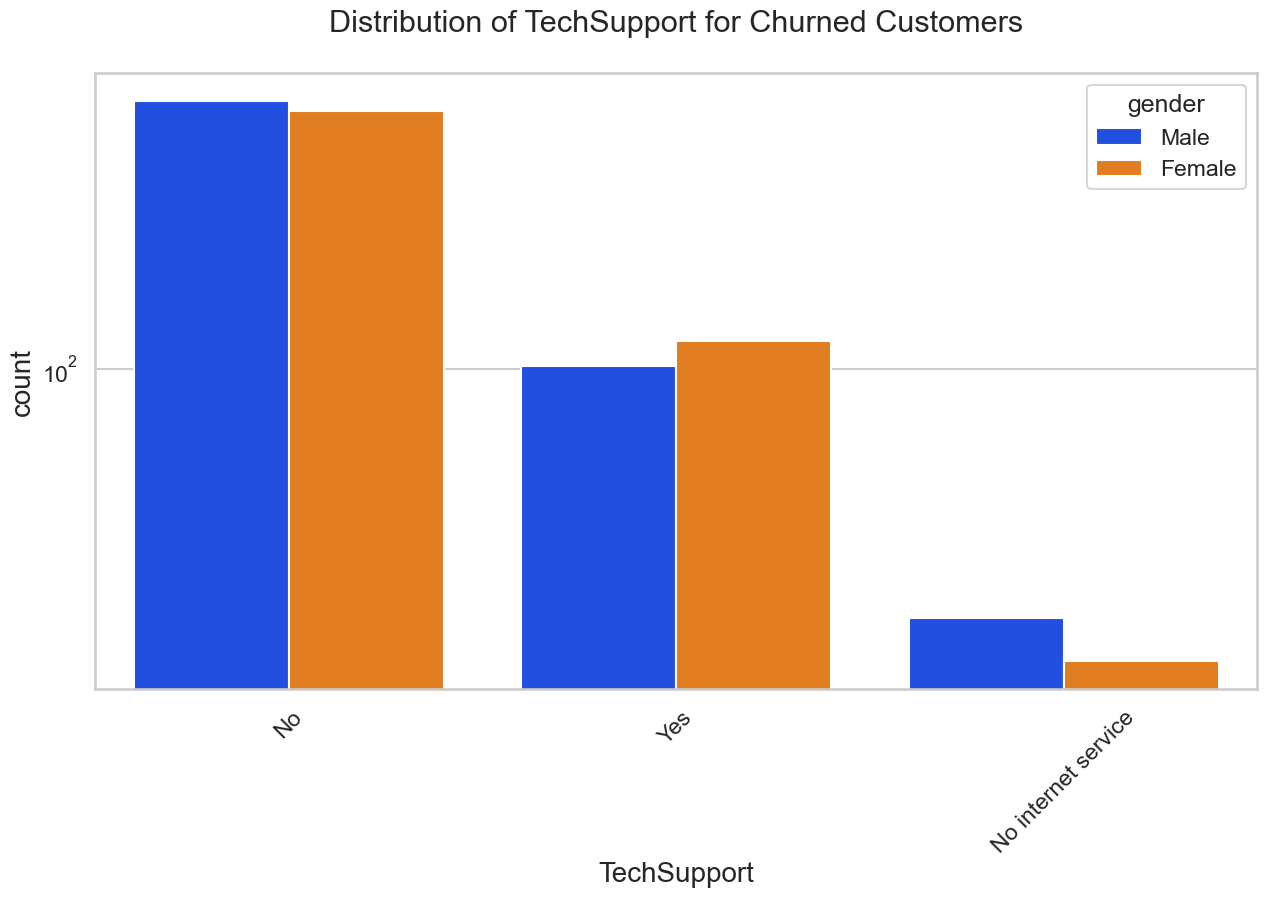

In [152]:
uniplot(new_df1_target1,col='TechSupport',title='Distribution of TechSupport for Churned Customers',hue='gender')

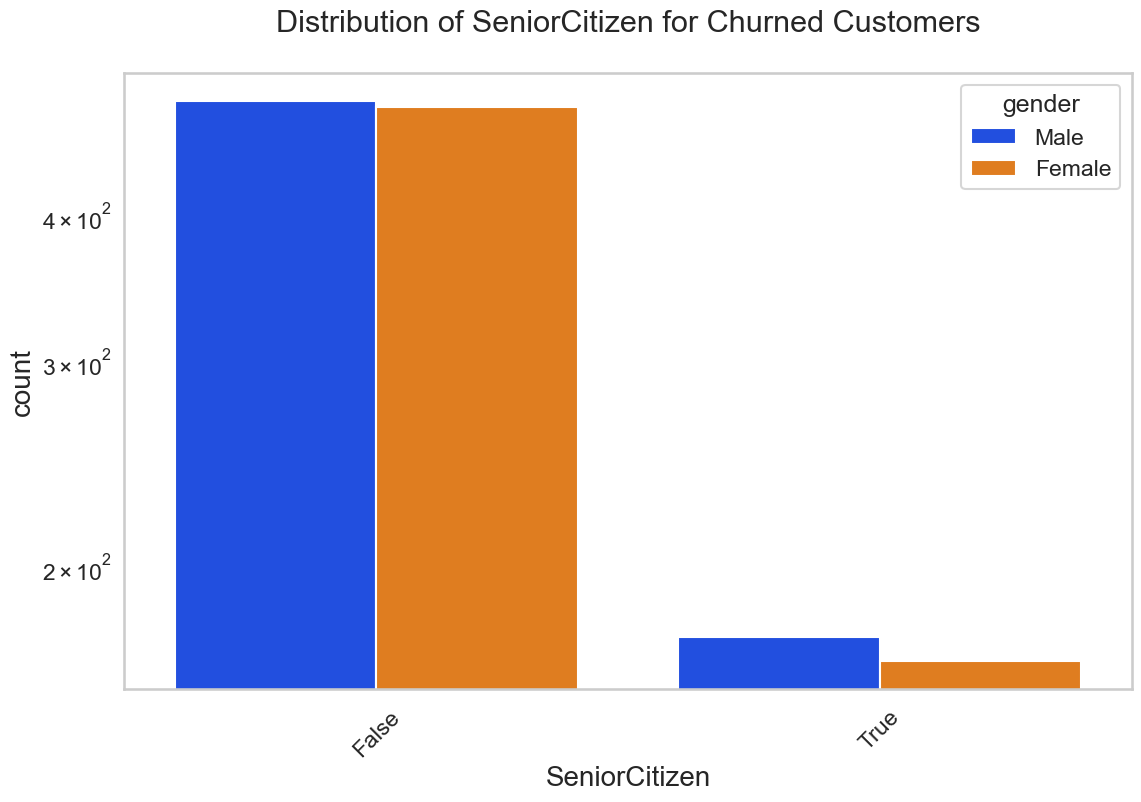

In [153]:
uniplot(new_df1_target1,col='SeniorCitizen',title='Distribution of SeniorCitizen for Churned Customers',hue='gender')

# CONCLUSIONS FROM EDA

These are some of the quick insights from this exercise:

1. Electronic check medium are the highest churners
2. Contract Type - Monthly customers are more likely to churn because of no contract terms, as they are free to go customers.
3. No Online security, No Tech Support category are high churners
4. Non senior Citizens are high churners

In [154]:
voda_data_dummies.to_csv('Voda_churn.csv')

# Model Building

#### Reading csv

In [155]:
df=pd.read_csv("Voda_churn.csv")
df.head()

,Unnamed: 0,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_False,SeniorCitizen_True,Partner_No,Partner_Yes,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,0,29.850000,29.850000,0,1,0,1,0,0,1,...,0,0,1,0,1,0,0,0,0,0
1,1,56.950001,1889.500000,0,0,1,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0
2,2,53.849998,108.150002,1,0,1,1,0,1,0,...,0,0,0,1,1,0,0,0,0,0
3,3,42.299999,1840.750000,0,0,1,1,0,1,0,...,1,0,0,0,0,0,0,1,0,0
4,4,70.699997,151.649994,1,1,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,0


In [156]:
df=df.drop('Unnamed: 0',axis=1)

In [157]:
x=df.drop('Churn',axis=1)
x

,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_False,SeniorCitizen_True,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,29.850000,29.850000,1,0,1,0,0,1,1,0,...,0,0,1,0,1,0,0,0,0,0
1,56.950001,1889.500000,0,1,1,0,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0
2,53.849998,108.150002,0,1,1,0,1,0,1,0,...,0,0,0,1,1,0,0,0,0,0
3,42.299999,1840.750000,0,1,1,0,1,0,1,0,...,1,0,0,0,0,0,0,1,0,0
4,70.699997,151.649994,1,0,1,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,84.800000,1990.500000,0,1,1,0,0,1,0,1,...,0,0,0,1,0,1,0,0,0,0
5039,103.200000,7362.900000,1,0,1,0,0,1,0,1,...,0,1,0,0,0,0,0,0,0,1
5040,29.600000,346.450000,1,0,1,0,0,1,0,1,...,0,0,1,0,1,0,0,0,0,0
5041,74.400000,306.600000,0,1,0,1,0,1,1,0,...,0,0,0,1,1,0,0,0,0,0


In [158]:
y=df['Churn']
y

0       0
1       0
2       1
3       0
4       1
       ..
5038    0
5039    0
5040    0
5041    1
5042    0
Name: Churn, Length: 5043, dtype: int64

##### Train Test Split

In [159]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

#### Decision Tree Classifier

In [160]:
model_dt=DecisionTreeClassifier(criterion = "gini",random_state = 100,max_depth=6, min_samples_leaf=8)

In [161]:
model_dt.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=8, random_state=100)

In [162]:
y_pred=model_dt.predict(x_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [163]:
model_dt.score(x_test,y_test)

0.7839444995044599

In [164]:
print(classification_report(y_test, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       720
           1       0.66      0.51      0.57       289

    accuracy                           0.78      1009
   macro avg       0.74      0.70      0.71      1009
weighted avg       0.77      0.78      0.77      1009



###### As you can see that the accuracy is quite low, and as it's an imbalanced dataset, we shouldn't consider Accuracy as our metrics to measure the model, as Accuracy is cursed in imbalanced datasets.

###### Hence, we need to check recall, precision & f1 score for the minority class, and it's quite evident that the precision, recall & f1 score is too low for Class 1, i.e. churned customers.

###### Hence, moving ahead to call SMOTEENN (UpSampling + ENN)

In [166]:
sm = SMOTEENN()
X_resampled, y_resampled = sm.fit_resample(x,y)

In [168]:
xr_train,xr_test,yr_train,yr_test=train_test_split(X_resampled, y_resampled,test_size=0.2)

In [169]:
model_dt_smote=DecisionTreeClassifier(criterion = "gini",random_state = 100,max_depth=6, min_samples_leaf=8)

In [170]:
model_dt_smote.fit(xr_train,yr_train)
yr_predict = model_dt_smote.predict(xr_test)
model_score_r = model_dt_smote.score(xr_test, yr_test)
print(model_score_r)
print(metrics.classification_report(yr_test, yr_predict))

0.935672514619883
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       390
           1       0.93      0.95      0.94       465

    accuracy                           0.94       855
   macro avg       0.94      0.93      0.94       855
weighted avg       0.94      0.94      0.94       855

